In [1]:
import pandas as pd

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42 # editable text in matplotlib
mpl.rcParams['svg.fonttype'] = 'none'

# seaborn
import seaborn as sns
sns.set_style('ticks', rc={'axes.grid':True})
sns.set_context('talk')

# set matplotlib formats
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
def myScatter(ax, df, x, y, l, 
              s=20,
              sample_frac=None,
              sample_n=None,
              legend_size=None,
              legend_kws=None,
              grey_label='unlabeled',
              shuffle=True,
              random_state=None,
              legend_mode=0,
              kw_colors=False,
              colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C8', 'C9'], **kwargs):
    """
    - kw_colors is a dictinary {label: color}
    """
    # shuffle (and copy) data
    if sample_n:
        df = (df.groupby(l).apply(lambda x: x.sample(min(len(x), sample_n), random_state=random_state))
                            .reset_index(level=0, drop=True)
            )
    if sample_frac:
        df = (df.groupby(l).apply(lambda x: x.sample(frac=sample_frac, random_state=random_state))
                            .reset_index(level=0, drop=True)
            )
    if shuffle:
        df = df.sample(frac=1, random_state=random_state)

    if not kw_colors:
        # add a color column
        inds, catgs = pd.factorize(df[l])
        df['c'] = [colors[i%len(colors)] if catgs[i]!=grey_label else 'grey' 
                    for i in inds]
    else:
        df['c'] = [kw_colors[i] if i!=grey_label else 'grey' for i in df[l]]
    
    # take care of legend
    if legend_mode != -1:
        for ind, row in df.groupby(l).first().iterrows():
            ax.scatter(row[x], row[y], c=row['c'], label=ind, s=s, **kwargs)
        
    if legend_mode == -1:
        pass
    elif legend_mode == 0:
        lgnd = ax.legend()
    elif legend_mode == 1:
        # Shrink current axis's height by 10% on the bottom
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])
        lgnd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
              ncol=6, fancybox=False, shadow=False) 
    elif legend_mode == 2:
        # Shrink current axis's width by 10% on the bottom
        box = ax.get_position()
        ax.set_position([box.x0 + box.width*0.1, box.y0,
                                 box.width*0.8, box.height])

    if legend_kws:
        lgnd = ax.legend(**legend_kws)

    if legend_mode != -1 and legend_size:
        for handle in lgnd.legendHandles:
            handle._sizes = [legend_size] 

    # backgroud (grey)
    df_grey = df.loc[df['c']=='grey']
    if not df_grey.empty:
        ax.scatter(df_grey[x], 
                   df_grey[y],
                   c=df_grey['c'], s=s, **kwargs)
    # actual plot
    df_tmp = df.loc[df['c']!='grey']
    ax.scatter(df_tmp[x], 
               df_tmp[y],
               c=df_tmp['c'], s=s, **kwargs)
    
    return




def plot_tsne_labels_ax(df, ax, tx='tsne_x', ty='tsne_y', tc='cluster_ID', 
                    sample_frac=None,
                    sample_n=None,
                    legend_size=None,
                    legend_kws=None,
                    grey_label='unlabeled',
                    legend_mode=0,
                    s=1,
                    shuffle=True,
                    random_state=None,
                    t_xlim='auto', t_ylim='auto', title=None, 
                    legend_loc='lower right',
                    colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C8', 'C9'], **kwargs):
    """
    tSNE plot
    """
    myScatter(ax, df, tx, ty, tc,
             s=s,
             sample_frac=sample_frac,
             sample_n=sample_n,
             legend_size=legend_size,
             legend_kws=legend_kws,
             shuffle=shuffle,
             grey_label=grey_label,
             random_state=random_state, 
             legend_mode=legend_mode, 
             colors=colors, **kwargs)

    if title:
        ax.set_title(title)
    else:
        ax.set_title(tc)
    ax.set_xlabel(tx)
    ax.set_ylabel(ty)
    # ax.set_aspect('auto')

    if t_xlim == 'auto':
        t_xlim = [np.nanpercentile(df[tx].values, 0.1), np.nanpercentile(df[tx].values, 99.9)]
        t_xlim[0] = t_xlim[0] - 0.1*(t_xlim[1] - t_xlim[0])
        t_xlim[1] = t_xlim[1] + 0.1*(t_xlim[1] - t_xlim[0])
        ax.set_xlim(t_xlim)
    elif t_xlim:
        ax.set_xlim(t_xlim)
    else:
        pass  

    if t_ylim == 'auto':
        t_ylim = [np.nanpercentile(df[ty].values, 0.1), np.nanpercentile(df[ty].values, 99.9)]
        t_ylim[0] = t_ylim[0] - 0.1*(t_ylim[1] - t_ylim[0])
        t_ylim[1] = t_ylim[1] + 0.1*(t_ylim[1] - t_ylim[0])
        ax.set_ylim(t_ylim)
    elif t_ylim:
        ax.set_ylim(t_ylim)
    else:
        pass

    return


# Data 

In [3]:
f_joint_clustering = './cell_table.tsv'
f_cluster_annot = './cluster_annotation.tsv'
f_mod_annot = './dataset_annotation.tsv'

In [4]:
!ls

cell_table.tsv		dataset_annotation.tsv
cluster_annotation.tsv	flagship_fig2a.ipynb


In [5]:
# get results summary
mods_ordered = [
    'smarter_cells',
    '10x_cells_v3',
    '10x_cells_v2', 
    'smarter_nuclei',
    '10x_nuclei_v3_macosko',
    '10x_nuclei_v3',
    'snatac_gene',
    'snmcseq_gene',
    ]

f = f_cluster_annot
df_annot = pd.read_csv(f, sep="\t") 

f = f_mod_annot
df_mod_annot = pd.read_csv(f, sep="\t", index_col='Modality') 

f = f_joint_clustering
df_info = pd.read_csv(f, sep="\t") 

# back compatible
df_info = pd.merge(df_info, df_mod_annot[['Name']], left_on='modality', right_index=True)
df_info = pd.merge(df_info, df_annot[['cluster_id_iterative', 'annotation_curated', 'color']], 
                   left_on='joint_cluster_round3', right_on='cluster_id_iterative', )
df_info = df_info.rename(columns={
                'joint_embedding_x': 'tsne_x_joint',
                'joint_embedding_y': 'tsne_y_joint',
                'single_modality_annot': 'annot',
                'single_modality_cluster': 'cluster',
                'annotation_curated': 'joint_cluster_round3_anno',
                'color': 'joint_cluster_round3_color',
            }).drop('cluster_id_iterative', axis=1)
df_info = df_info.set_index('sample')
df_info = df_info.astype({"cluster": str})

print(df_info.shape)
df_info.head()


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(408885, 13)


,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot,joint_cluster_round1,joint_cluster_round2,joint_cluster_round3,joint_cluster_round4,Name,joint_cluster_round3_anno,joint_cluster_round3_color
sample,,,,,,,,,,,,,
snmcseq_gene_2C_M_0,0.471629,-3.134735,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2,1,1-1,1-1-1,1-1-1-1,DNA methylation,L4/5 IT (1),#3CBC78
snmcseq_gene_2C_M_1011,-0.091199,-2.604921,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2,1,1-1,1-1-1,1-1-1-1,DNA methylation,L4/5 IT (1),#3CBC78
snmcseq_gene_2C_M_1012,-0.037576,-8.106225,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,1,1-1,1-1-1,1-1-1-1,DNA methylation,L4/5 IT (1),#3CBC78
snmcseq_gene_2C_M_1022,0.906631,-0.785923,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Cpne4,L4-IT-Rorb_Rorb-Cpne4,1,1-1,1-1-1,1-1-1-1,DNA methylation,L4/5 IT (1),#3CBC78
snmcseq_gene_2C_M_1024,1.627603,-1.945875,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Cpne4,L4-IT-Rorb_Rorb-Cpne4,1,1-1,1-1-1,1-1-1-1,DNA methylation,L4/5 IT (1),#3CBC78


In [6]:
joint_clst_colors = df_annot.set_index('cluster_id_iterative')['color'].to_dict()

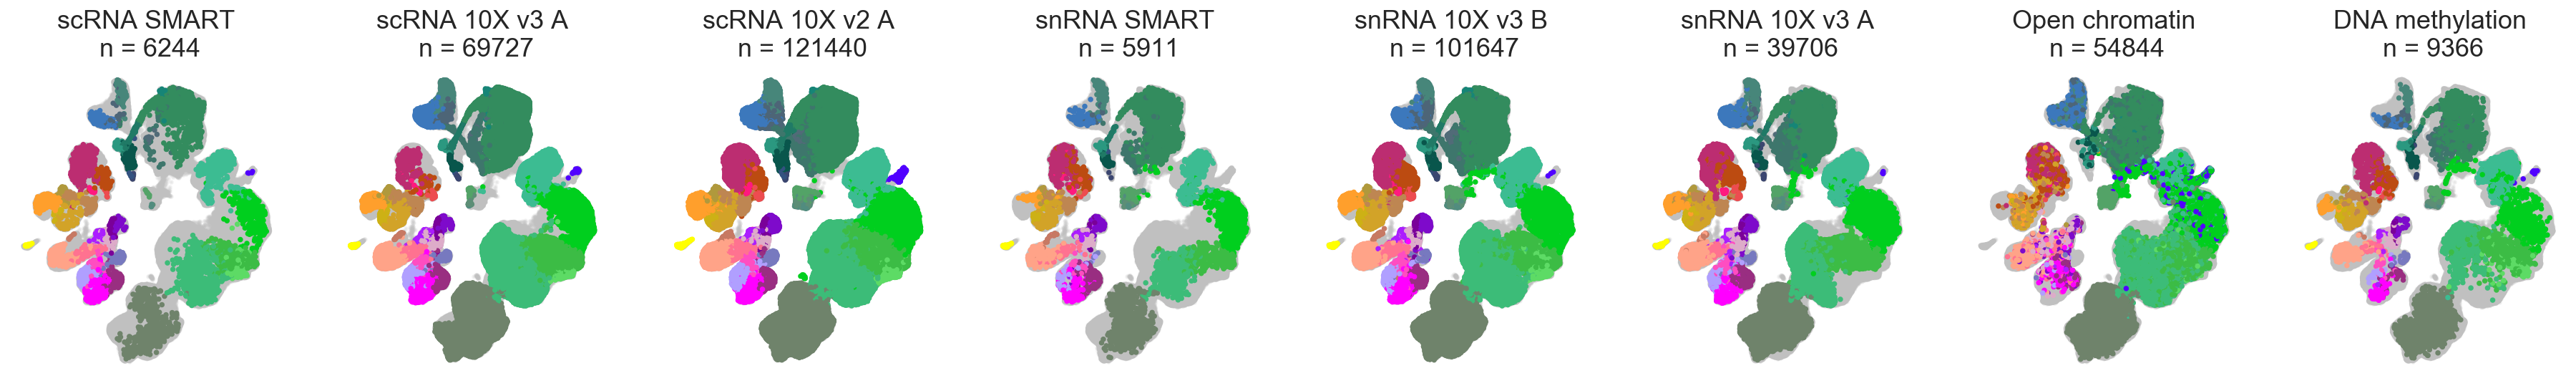

In [7]:
n = len(mods_ordered)
nx = 8
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
axs = axs.flatten()
for mod, ax in zip(mods_ordered, axs):
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'joint_cluster_round3'
    ax.scatter(df_info[tx].values, df_info[ty].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                        t_xlim=None, t_ylim=None,
                        legend_mode=-1,
                        rasterized=True,
                        kw_colors=joint_clst_colors,
                        s=5,
                       )
    ax.set_title('{}\n n = {}'.format(df_mod_annot.loc[mod, 'Name'], 
                                    len(df_info.loc[(df_info['modality']==mod)]), 
                                    ))
    ax.axis('off')

for ax in axs[n:]:
    ax.axis('off')
# fig.savefig('fig2a.pdf', bbox_inches='tight', dpi=300)
plt.show()